In [10]:
! pip install imbalanced-learn
! pip install collections


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 KB 4.6 MB/s eta 0:00:002.7 MB/s eta 0:00:01
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_parquet('versao_2_spotify_songs.parquet')

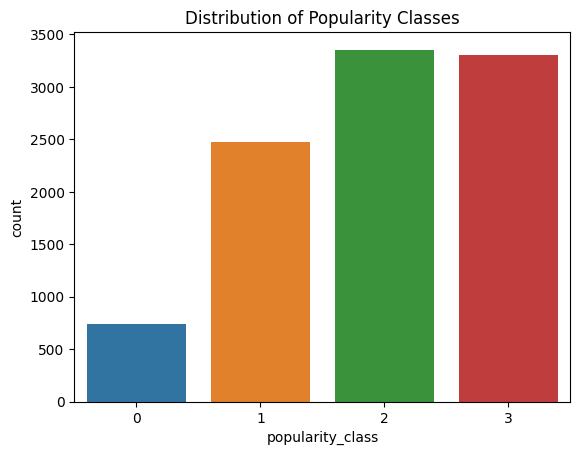

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of popularity classes
sns.countplot(x='popularity_class', data=df)
plt.title('Distribution of Popularity Classes')
plt.show()


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9864 entries, 7 to 36
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   playlist_genre     9864 non-null   object 
 1   playlist_subgenre  9864 non-null   object 
 2   danceability       9864 non-null   float64
 3   energy             9864 non-null   float64
 4   key                9864 non-null   int64  
 5   loudness           9864 non-null   float64
 6   mode               9864 non-null   int64  
 7   speechiness        9864 non-null   float64
 8   acousticness       9864 non-null   float64
 9   instrumentalness   9864 non-null   float64
 10  liveness           9864 non-null   float64
 11  valence            9864 non-null   float64
 12  tempo              9864 non-null   float64
 13  duration_ms        9864 non-null   int64  
 14  popularity_class   9864 non-null   int64  
dtypes: float64(9), int64(4), object(2)
memory usage: 1.2+ MB


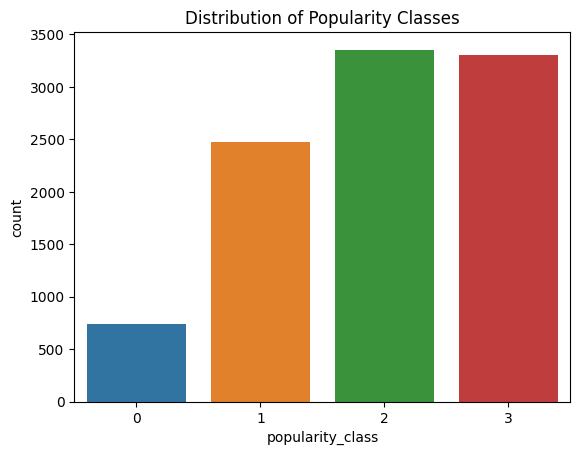

In [8]:
# Distribution of popularity classes
sns.countplot(x='popularity_class', data=df)
plt.title('Distribution of Popularity Classes')
plt.show()



In [11]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
# separando quem é feature e quem é target
X = df.drop(columns=[ 'popularity_class'])
y = df['popularity_class']

# Splitting dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Original dataset shape", Counter(y_train))

sm = RandomUnderSampler(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("Dataset shape undersampling", Counter(y_res))

Original dataset shape Counter({2: 2676, 3: 2643, 1: 1978, 0: 594})
Dataset shape undersampling Counter({0: 594, 1: 594, 2: 594, 3: 594})


In [ ]:
# SVM - TESTAR MAIS HIPERPARAMETROS
svm_model = SVC(kernel='linear')  # You can try different kernels and hyperparameters

# Treinando modelo
svm_model.fit(X_res, y_res)

# Predict
predictions = svm_model.predict(X_test)

# Avaliando
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(conf_mat = cm, show_normed = True, class_names = [0,1,2,3])

In [ ]:
# SVM - TESTAR MAIS HIPERPARAMETROS
svm_model_sem_under = SVC(kernel='linear')  # You can try different kernels and hyperparameters

# Treinando modelo
svm_model_sem_under.fit(X_train, y_train)

# Predict
predictions_sem_under = svm_model_sem_under.predict(X_test)

# Avaliando
print(classification_report(y_test, predictions_sem_under))
print("Accuracy:", accuracy_score(y_test, predictions_sem_under))

In [ ]:
cm_sem_under = confusion_matrix(y_test, predictions_sem_under)
plot_confusion_matrix(conf_mat = cm_sem_under, show_normed = True, class_names = [0,1,2,3])